# RTML Lab 2: AlexNet vs. GoogLeNet
# Chanapa Pananookooln | st121395

For this lab I implemented everything in .py files using vscode.
I create one .py file for each model class and one py. file as the main file for training and testing that will call the classes from other files. I also save the best model and the accuracy and loss history for testing and plotting later. In this lab report I will be posting some code snippets here and also some screenshots of training in vscode as evidence. 

In [27]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

### Define a function for plotting Loss and Accuracy as a function of EPOCHs

In [28]:
def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

## Train function from def_train_model.py

In [29]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, weights_name='weight_save', is_inception=False):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the train/validation dataset according to which phase we're in
            
            for inputs, labels in dataloaders[phase]:

                # Inputs is one batch of input images, and labels is a corresponding vector of integers
                # labeling each image in the batch. First, we move these tensors to our target device.
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out any parameter gradients that have previously been calculated. Parameter
                # gradients accumulate over as many backward() passes as we let them, so they need
                # to be zeroed out after each optimizer step.

                optimizer.zero_grad()

                # Instruct PyTorch to track gradients only if this is the training phase, then run the
                # forward propagation and optionally the backward propagation step for this iteration.

                with torch.set_grad_enabled(phase == 'train'):
                    # The inception model is a special case during training because it has an auxiliary
                    # output used to encourage discriminative representations in the deeper feature maps.
                    # We need to calculate loss for both outputs. Otherwise, we have a single output to
                    # calculate the loss on.
                    
                    # For GOOGLENET
                    if is_inception and phase == 'train': #  USE THE AUXILLARY OUTPUT FOR TRAINING
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs2, aux_outputs3 = model(inputs)
                        # outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs2, labels)
                        loss3 = criterion(aux_outputs3, labels)
                        loss = loss1 + (0.3 * loss2) + (0.3 * loss3)
                    else:
                        # outputs = model(inputs) # FOR ALEXNET
                        outputs, aux_outputs2, aux_outputs3 = model(inputs)
                        # need to modify here when using pre-trained google net because
                        # when we do model.eval() it will return only one argument automatically
                        # But for the scratch model we need to accept all 3 outputs but at val we only use loss from final output to back prop
                        
                        
                        loss = criterion(outputs, labels) 
                    
                    outputs = F.softmax(outputs, dim=1)
                    _, preds = torch.max(outputs, 1)

                    # Backpropagate only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # If this is the best model on the validation set so far, deep copy it
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    # Output summary statistics, load the best weight set, and return results
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

## Test function from def_test_model.py
I also adapt the train function to create a function for getting the test loss and test accuracy from a separated test dataset.

In [30]:
def test_model(model, dataloaders, criterion, device):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
            
    for inputs, labels in dataloaders['test']:

        # Inputs is one batch of input images, and labels is a corresponding vector of integers
        # labeling each image in the batch. First, we move these tensors to our target device.
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs, aux1, aux2 = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        # Gather our summary statistics        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(dataloaders['test'].dataset)
    test_acc = running_corrects.double() / len(dataloaders['test'].dataset)
    test_end = time.time()

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', test_loss, test_acc))

    return test_acc, test_loss

# AlexNet Implementation from Scratch

For AlexNet I tried implementing from both Pytorch nn.Sequential and nn.module then compare the results.

I also incorporate Local Response Normalization into the models as described in the paper.
LRN is inserted into convolutional layer 1 and 2 after ReLU, before MaxPooling. The parameters of LRN are set according to the paper. 

        nn.LocalResponseNorm(size=5,alpha=1e-4, beta=0.75, k=2)

Then I will compare the accuracy of the models implemented with nn.Sequential and nn.Module, with and without LRN.

## Implement AlexNet using nn.Sequential with and without LRN



In [31]:
class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

NUM_CLASSES = 10

alex_seq_LRN = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.LocalResponseNorm(size=5,alpha=1e-4, beta=0.75, k=2), # added LRN
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.LocalResponseNorm(size=5,alpha=1e-4, beta=0.75, k=2), # added LRN
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),

    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),

    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    nn.Dropout(),

    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),

    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),

    nn.Linear(4096, NUM_CLASSES)
    )

alex_seq = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),

    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),

    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.AdaptiveAvgPool2d((6, 6)),
    Flatten(),
    nn.Dropout(),

    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),

    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    
    nn.Linear(4096, NUM_CLASSES)
    )

## Implement AlexNet using nn.Module with and without LRN

In [32]:
class AlexNetModule_LRN(nn.Module):
    '''
    An AlexNet-like CNN

    Attributes
    ----------
    num_classes : int
        Number of classes in the final multinomial output layer
    features : Sequential
        The feature extraction portion of the network
    avgpool : AdaptiveAvgPool2d
        Convert the final feature layer to 6x6 feature maps by average pooling if they are not already 6x6
    classifier : Sequential
        Classify the feature maps into num_classes classes
    '''
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5,alpha=1e-4, beta=0.75, k=2), # added LRN
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5,alpha=1e-4, beta=0.75, k=2), # added LRN
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class AlexNetModule(nn.Module):
    '''
    An AlexNet-like CNN

    Attributes
    ----------
    num_classes : int
        Number of classes in the final multinomial output layer
    features : Sequential
        The feature extraction portion of the network
    avgpool : AdaptiveAvgPool2d
        Convert the final feature layer to 6x6 feature maps by average pooling if they are not already 6x6
    classifier : Sequential
        Classify the feature maps into num_classes classes
    '''
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

I trained the 4 models using the configuration that professor recommended for lab1.

Last time professor also mentioned that if we train the model from scratch we should normalize that data with mean = (0.5, 0.5, 0.5) and std = (0.5, 0.5, 0.5) so this time as our models are trained from scratch I tried data augmentation and normalization as the following.

        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

For optimazation, I used SGD with the following configuration.

        lr=0.001
        momentum=0.9
        weight_decay=0.0005
        momentum=0.9

I train each model for 10 epochs, with batch size = 4.

Here is an example of my main .py file for training AlexNet.


In [ ]:
#%%
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
import numpy as np

#%%
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=preprocess)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                               shuffle=True, num_workers=2)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=2)
                                             
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                              shuffle=False, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

#%%
# Define the models, criterion, optimizer and EPOCH
from def_train_model import train_model
from AlexNetSeq import alex_seq_LRN

alex_seq_LRN = alex_seq_LRN.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(alex_seq_LRN.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

print(alex_seq_LRN)
#%%
best_model, val_acc_history, loss_history = train_model(alex_seq_LRN, dataloaders, criterion, optimizer, device, 10, 'alex_seq_LRN_lr_0.001_bestsofar')

val_acc_history = np.array(val_acc_history)
np.save('alex_seq_LRN_val_acc_history.npy', val_acc_history)

loss_history = np.array(loss_history)
np.save('alex_seq_LRN_loss_history.npy', loss_history)


#%%
#Test the model
from def_test_model import test_model

# Load and use the best model for testing the accuracy
alex_seq_LRN.load_state_dict(torch.load('labs/weights/googlenet/alex_seq_LRN_lr_0.001_bestsofar.pth'))
test_dataloaders = { 'test': test_dataloader }
test_acc, test_loss = test_model(alex_seq_LRN, test_dataloaders, criterion, device)


### Example of training the model on VScode

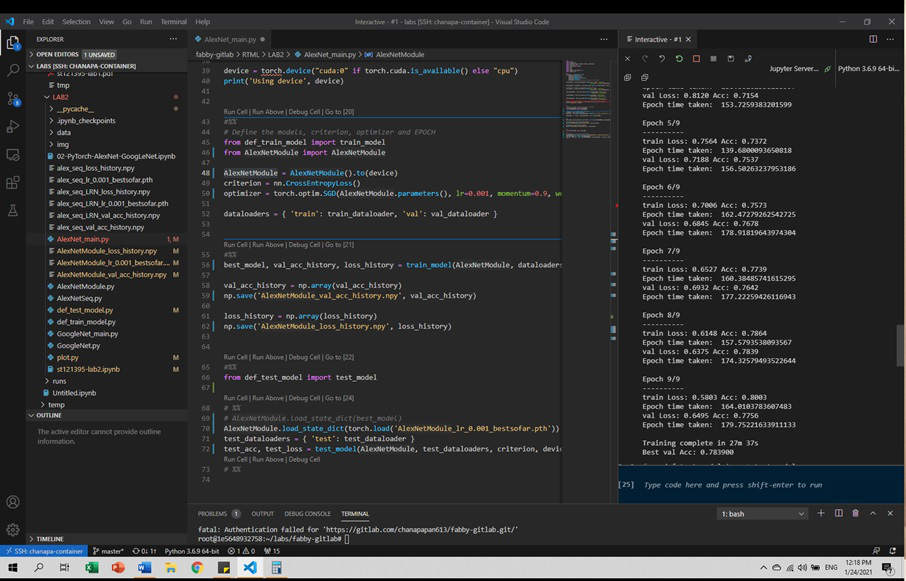

In [10]:
display(Image.open("alexscreen.jpg"))

# AlexNet Results

## AlexNet nn.Sequential (no LRN)

        Epoch 9/9
        ----------
        train Loss: 0.5600 Acc: 0.8090
        Epoch time taken:  151.85488271713257
        val Loss: 0.6069 Acc: 0.7917
        Epoch time taken:  166.89047193527222

        Training complete in 31m 11s
        Best val Acc: 0.793500

        test Loss: 0.6136 Acc: 0.7920




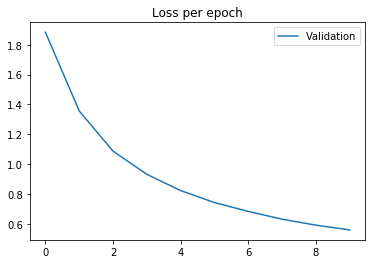

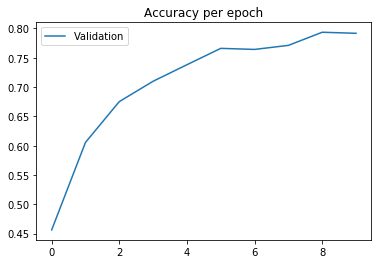

In [12]:
alex_seq_acc = np.load('./plot/alex_seq_val_acc_history.npy', allow_pickle=True)
alex_seq_loss = np.load('./plot/alex_seq_loss_history.npy', allow_pickle=True)
plot_data(alex_seq_acc, alex_seq_loss)

## AlexNet nn.Module (no LRN)

        Epoch 9/9
        ----------
        train Loss: 0.5803 Acc: 0.8003
        Epoch time taken:  164.0103783607483
        val Loss: 0.6495 Acc: 0.7756
        Epoch time taken:  179.75221633911133

        Training complete in 27m 37s
        Best val Acc: 0.783900

        test Loss: 0.6343 Acc: 0.7843


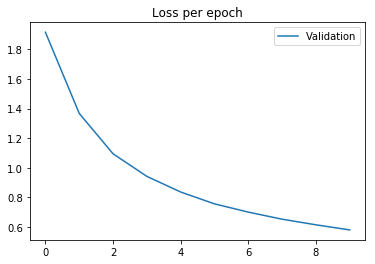

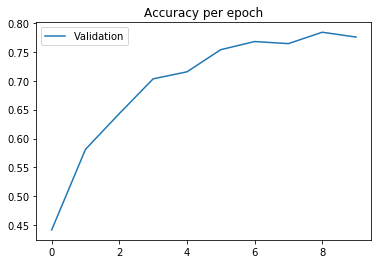

In [13]:
alex_mod_acc = np.load('./plot/AlexNetModule_val_acc_history.npy', allow_pickle=True)
alex_mod_loss = np.load('./plot/AlexNetModule_loss_history.npy', allow_pickle=True)
plot_data(alex_mod_acc, alex_mod_loss)

## AlexNet nn.Sequential with LRN

        Epoch 9/9
        ----------
        train Loss: 0.5897 Acc: 0.7991
        Epoch time taken:  177.98811650276184
        val Loss: 0.6406 Acc: 0.7807
        Epoch time taken:  194.60889863967896

        Training complete in 31m 29s
        Best val Acc: 0.785100 

        test Loss: 0.6267 Acc: 0.7867 



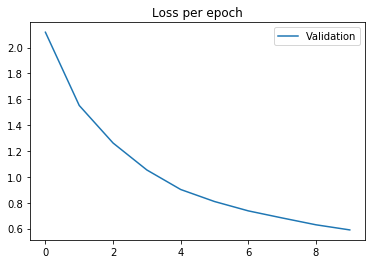

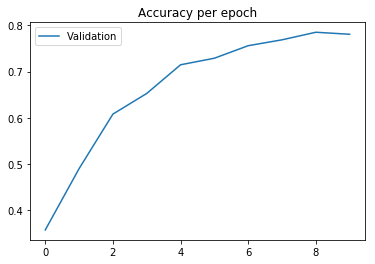

In [16]:
alex_seqLRN_acc = np.load('./plot/alex_seq_LRN_val_acc_history.npy', allow_pickle=True)
alex_seqLRN_loss = np.load('./plot/alex_seq_LRN_loss_history.npy', allow_pickle=True)
plot_data(alex_seqLRN_acc, alex_seqLRN_loss)

## AlexNet nn.Module with LRN

        Epoch 9/9
        ----------
        train Loss: 0.6033 Acc: 0.7923
        Epoch time taken:  191.43243885040283
        val Loss: 0.6167 Acc: 0.7892
        Epoch time taken:  208.41649675369263

        Training complete in 33m 37s
        Best val Acc: 0.789200

        test Loss: 0.6248 Acc: 0.7875


       


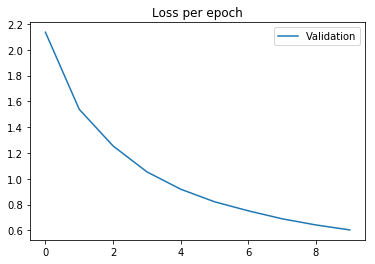

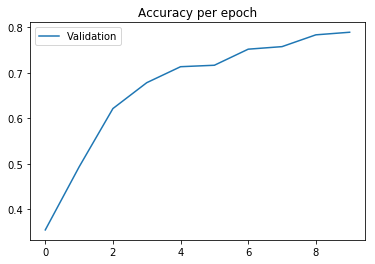

In [17]:
alex_modLRN_acc = np.load('./plot/AlexNetModule_LRN_val_acc_history.npy', allow_pickle=True)
alex_modLRN_loss = np.load('./plot/AlexNetModule_LRN_loss_history.npy', allow_pickle=True)
plot_data(alex_modLRN_acc, alex_modLRN_loss)

## Comparing the result of nn.Sequential AlexNet and nn.Module AlexNet with and without LRN
From the graphs we can see that all 4 models are converging quite well.

The run time for all models is approximately 160-200s per epoch which total to 27-33 min per 10 epochs.
There is no significant difference between nn.Sequencial and nn.Module or with and without LRN.

The validation and test results of all 4 models are very similar.

They all have validation and test accuracy at around 78-79% and test loss at 0.61-0.63 with, again, no significant difference between nn.Sequential and nn.Module or with and without LRN.

Test set losses are still higher than or about the same as validation loss which indicates that there are no overfitting.

From this experiment it can be concluded that LRN does not have a significant effect on the accuracy or the performance of AlexNet models which contrasts with what the paper has stated.


## Comparing the results from AlexNet from scratch and ALexNet Pretrained from Lab1
From Lab1 I tried fine-tuning the pre-trained AlexNet and got validation set accuracy = 100% and the highest test set accuracy of 89%.
So the accuracy of the scratch model is about 10% lower than the pre-trained one.

I think there are still many hyperparameter of the optimizer and a lot of data augmentation that I can try to optimize my scratch AlexNet model and allows more generalization to hopefully get higher accuracy, closer to the pre-trained model. It may also need more epochs to train not just 10.

# GoogLeNet Implementation from Scratch

For GoogleNet there are 2 classes needed to create the model, the Inception class for the Inception Module and the GoogleNet class where we stack many Inception Modules together.

From the given architecture in class I need to modify some parts so that the architecture corresponds to what was described in the paper.

I did not edit the Inception class but I edited some parts in the GoogleNet class.

In the pre-layers part I added 2 more convolutional layers together with MaxPooling and LRN.

I also added the 2 auxillary branches which split out from a4 and d4 Inception module.

Here we have to modify the training function. When we add the auxillary branches, we will get 3 outputs from the model then we need to use the 3 outputs to calculate the losses. According to the paper, we multiply the losses from the auxillary branch by 0.3, then add them up with the loss from the main classifier. The total loss is used to do backpropagate.

When evaluating the model we ignore the auxillary outputs and only use the main classifier to calculate tha validation loss and accuracy.

Here is the architecture of the GoogleNet model that I used.

In [33]:
class Inception(nn.Module):
    '''
    Inception block for a GoogLeNet-like CNN

    Attributes
    ----------
    in_planes : int
        Number of input feature maps
    n1x1 : int
        Number of direct 1x1 convolutions
    n3x3red : int
        Number of 1x1 reductions before the 3x3 convolutions
    n3x3 : int
        Number of 3x3 convolutions
    n5x5red : int
        Number of 1x1 reductions before the 5x5 convolutions
    n5x5 : int
        Number of 5x5 convolutions
    pool_planes : int
        Number of 1x1 convolutions after 3x3 max pooling
    b1 : Sequential
        First branch (direct 1x1 convolutions)
    b2 : Sequential
        Second branch (reduction then 3x3 convolutions)
    b3 : Sequential
        Third branch (reduction then 5x5 convolutions)
    b4 : Sequential
        Fourth branch (max pooling then reduction)
    '''
    
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        self.in_planes = in_planes
        self.n1x1 = n1x1
        self.n3x3red = n3x3red
        self.n3x3 = n3x3
        self.n5x5red = n5x5red
        self.n5x5 = n5x5
        self.pool_planes = pool_planes
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)



class GoogLeNet(nn.Module):
    '''
    GoogLeNet-like CNN

    Attributes
    ----------
    pre_layers : Sequential
        Initial convolutional layer
    a3 : Inception
        First inception block
    b3 : Inception
        Second inception block
    maxpool : MaxPool2d
        Pooling layer after second inception block
    a4 : Inception
        Third inception block
    b4 : Inception
        Fourth inception block
    c4 : Inception
        Fifth inception block
    d4 : Inception
        Sixth inception block
    e4 : Inception
        Seventh inception block
    a5 : Inception
        Eighth inception block
    b5 : Inception
        Ninth inception block
    avgpool : AvgPool2d
        Average pool layer after final inception block
    linear : Linear
        Fully connected layer
    '''

    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                        nn.ReLU(True),
                        nn.MaxPool2d(3, stride=2, padding=1),
                        nn.LocalResponseNorm(size=5,alpha=1e-4, beta=0.75, k=2),

                        nn.Conv2d(64, 64, kernel_size=1),
                        nn.ReLU(True),

                        nn.Conv2d(64, 192, kernel_size=3,padding=1),
                        nn.ReLU(True),
                        nn.LocalResponseNorm(size=5,alpha=1e-4, beta=0.75, k=2)
        )        

        self.a3 = Inception(192,  64,  96, 128, 16, 32, 32)
        self.b3 = Inception(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.aux1 = nn.Sequential(nn.AvgPool2d(5, stride=3),
                                nn.Conv2d(512,128, kernel_size=1),
                                nn.ReLU(True),
                                Flatten(),
                                nn.Linear(2048,1024),
                                nn.ReLU(True),
                                nn.Dropout(0.7),
                                nn.Linear(1024,10)
                                )

        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.aux2 = nn.Sequential(nn.AvgPool2d(5, stride=3),
                                nn.Conv2d(528,128, kernel_size=1),
                                nn.ReLU(True),
                                Flatten(),
                                nn.Linear(2048,1024),
                                nn.ReLU(True),
                                nn.Dropout(0.7),
                                nn.Linear(1024,10)
                                )
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.pre_layers(x)
        out = self.maxpool(out)

        out = self.a3(out)
        out = self.b3(out)

        out = self.maxpool(out)

        out = self.a4(out)
        aux_out1 = self.aux1(out)

        out = self.b4(out)
        out = self.c4(out)

        out = self.d4(out)
        aux_out2 = self.aux2(out)

        out = self.e4(out)
        out = self.maxpool(out)

        out = self.a5(out)
        out = self.b5(out)

        out = self.avgpool(out)
        out = self.dropout(out)

        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out, aux_out1, aux_out2

I trained the GoogleNet model from scratch using these configurations.

        preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

        optimizer = optim.SGD(GoogLeNet.parameters(), lr=0.01)

The model was trained for 10 epochs with batch size = 4.

This is the result

        Epoch 9/9
        ----------
        train Loss: 0.5752 Acc: 0.8937
        Epoch time taken:  873.4543738365173
        val Loss: 0.4596 Acc: 0.8510
        Epoch time taken:  941.6350722312927

        Training complete in 159m 20s
        Best val Acc: 0.851000

        test Loss: 0.5315 Acc: 0.8251



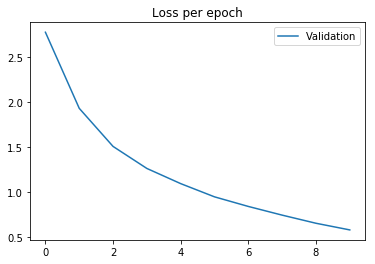

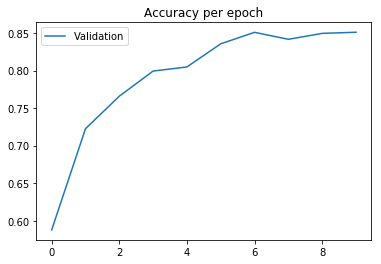

In [34]:
goognet_acc = np.load('./plot/GoogLeNet_val_acc_history.npy', allow_pickle=True)
goognet_loss = np.load('./plot/GoogLeNet_loss_history.npy', allow_pickle=True)
plot_data(goognet_acc, goognet_loss)

Before using this configuration I experimented with many settings such as Adam optimizer, normalizing the data with mean = (0.5, 0.5, 0.5) and std = (0.5, 0.5, 0.5) or with RandomHorizontalFlip and RandomCrop.
I also tried normalizing the data with 

        transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))])

but with all of these settings the model takes about 1200 s per epoch to train, so 10 epoch takes 4-6 hours and the accuracy always got stuck at around 72%.

Not until I changed the normalization to 

        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
        
and use only CenterCrop, that the model run time per epoch decreases to about 800-900s and the accuracy increases to more than 80 percent.



### Example of training GoogLeNet on VScode

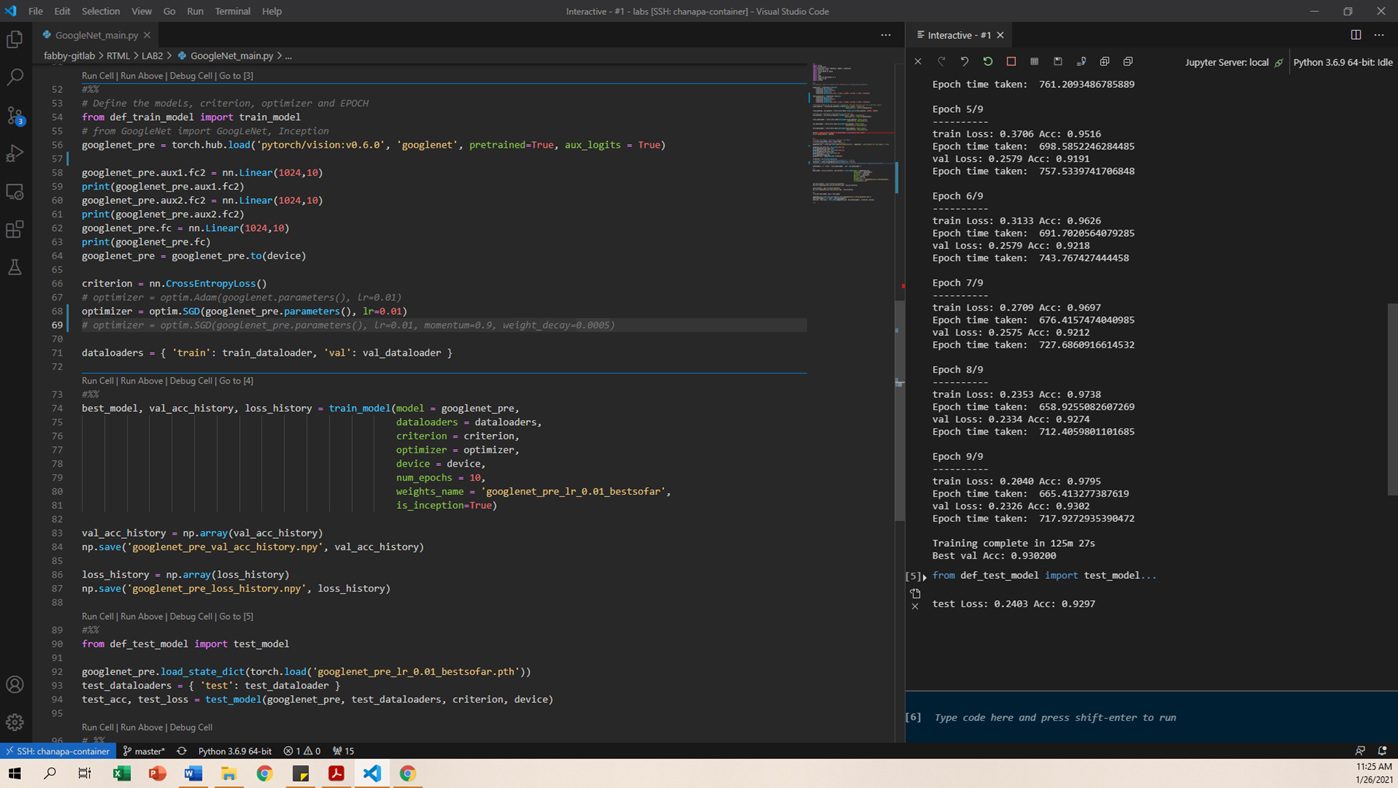

In [16]:
display(Image.open("googscreen.jpg"))

# Pre-trained GoogLeNet

I used torch.hub to download pre-trained GoogleNet from Pytorch.

I also modified the last fully-connected layer of the main and the auxillary classifier to end with 10-way softmax, as the following.

        googlenet_pre = torch.hub.load('pytorch/vision:v0.6.0', 'googlenet', pretrained=True, aux_logits = True)
        googlenet_pre.aux1.fc2 = nn.Linear(1024,10)
        googlenet_pre.aux2.fc2 = nn.Linear(1024,10)
        googlenet_pre.fc = nn.Linear(1024,10)

Then, I trained the pre-trained model using the same configuration that I used with the GoogleNet from-scratch model

But I use a test data that is transformed differently, using RandomCrop

        test_preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

This is the result.

        Epoch 9/9
        ----------
        train Loss: 0.2040 Acc: 0.9795
        Epoch time taken:  665.413277387619
        val Loss: 0.2326 Acc: 0.9302
        Epoch time taken:  717.9272935390472

        Training complete in 125m 27s
        Best val Acc: 0.930200

        test Loss: 0.2403 Acc: 0.9297


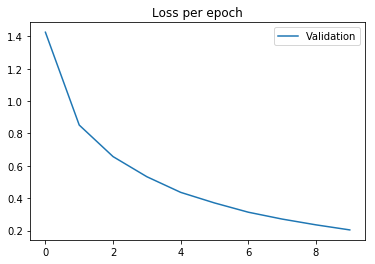

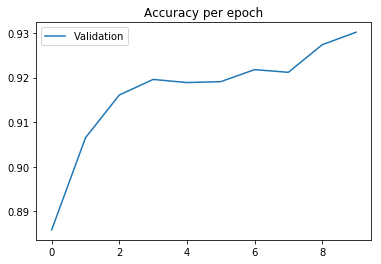

In [6]:
goognetpre_acc = np.load('./plot/googlenet_pre_val_acc_history.npy',allow_pickle=True)
goognetpre_loss = np.load('./plot/googlenet_pre_loss_history.npy',allow_pickle=True)
plot_data(goognetpre_acc, goognetpre_loss)

# Comparing AlexNet from scratch with GoogLeNet from scratch



In [18]:
# define a function for counting the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [25]:
alexnet = AlexNetModule()
googlenet = GoogLeNet()

models = [alexnet, googlenet]

for model in models:
    print(f'{type(model).__name__} has {count_parameters(model):,} trainable parameters')

AlexNetModule has 57,044,810 trainable parameters
GoogLeNet has 10,635,134 trainable parameters


### Parameters
As seen above AlexNet has 57 million parameters which is a lot more than GoogleNet that has only 10 million parameters.

### Speed of Training
AlexNet only takes 160-200s per epoch to train but GoogleNet takes a lot longer with 800-900s per epoch.

### Accuracy
Training from scratch with 10 epochs, AlexNet got validation and test accuracy at around 78-79% but GoogleNet got higher validation accuracy of 85% and test accuracy of 82% and also lower validation loss.

# Comparing pre-trained AlexNet with pre-trained GoogLeNet

Comparing the pre-trained AlexNet result from lab1 :

        Train Loss: 0.046 | Train Acc: 98.83%
        Val. Loss: 0.003 |  Val. Acc: 100.00%
        Test Loss: 0.446 | Test Acc: 89.53%   

with the pre-trained GoogleNet :

        Epoch 9/9
        ----------
        train Loss: 0.2040 Acc: 0.9795
        Epoch time taken:  665.413277387619
        val Loss: 0.2326 Acc: 0.9302
        Epoch time taken:  717.9272935390472

        Training complete in 125m 27s
        Best val Acc: 0.930200

        test Loss: 0.2403 Acc: 0.9297

We can see that GoogleNet gives higher test accuracy than AlexNet. This can be interpreted that GoogleNet have a larger learning capacity when compared to AlexNet which corresponds to what the paper stated when designing GoogleNet that it is a speciality of the Inception Modules.

In AlexNet's result the validation accuracy was 100% but, with the test set, the accuracy fell to 89%. However, in GoogleNet the validation accuracy is 93% and test set accuracy only falls to 92.9%.

The prominent fall of accuracy between validation set and test set in AlexNet could be interpreted that AlexNet has lower generalization capability so despite a 100% validation accuracy, it failed to generalize to the test set which results in a significant drop of test set accuracy. While GoogleNet clearly has higher generalization power.

# Conclusion

In this lab I learned a lot about mapping the theory in the papers to real application in Pytorch.
I would like to search and understand more about data augmentation in train and test set, also about the mean and std used in normalization. I learned that num_workers can be tune for more efficient computation.

Most importantly, this is my first time working on a project in .py format and also on VScode so everything is still very new and confusing for me. I am still not sure how to organize the codes in the .py files efficiently but I know that working with .py files would be very helpful in the future.